In [ ]:
# This is to ignore the warnings when running the code
import warnings 
warnings.filterwarnings('ignore')


## Importing Libraries

In [111]:
import trueq as tq
from trueq import Results
from qiskit.visualization import plot_histogram
import numpy as np
from qiskit import transpile
from qiskit_ibm_runtime import QiskitRuntimeService
from collections import defaultdict
from trueq import Results
import matplotlib.pyplot as plt

## Defining Backend

In [109]:
service = QiskitRuntimeService()
backend = service.backend('ibm_sherbrooke')
backend

<IBMBackend('ibm_sherbrooke')>

## Defining Circuit

In [ ]:
cycle1 = tq.Cycle({0: tq.Gate.x, 1:tq.Gate.y})
cycle2 = tq.Cycle({(0, 1): tq.Gate.cx}, marker=2)
cycle3 = tq.Cycle({0: tq.Gate.z, 1:tq.Gate.i})
cycle4 = tq.Cycle({0: tq.Gate.h, 1:tq.Gate.h},marker=2)
cycle5 = tq.Cycle({0: tq.Gate.x, 1:tq.Gate.z})

circuit = tq.Circuit([cycle1, cycle2, cycle3, cycle4, cycle5])
circuit.measure_all()
circuit_copy = circuit

circuit.draw()

DisplayWrapper(<svg xmlns="http://w...)

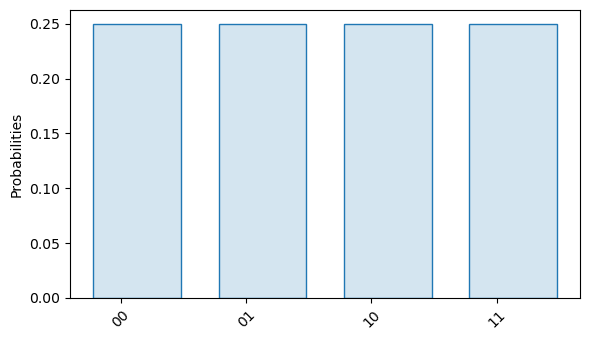

In [60]:
sim = tq.Simulator()
ideal_result = sim.sample(circuit, n_shots=np.inf) ## IDEAL OUTCOME IN TRUEQ
ideal_result.plot()

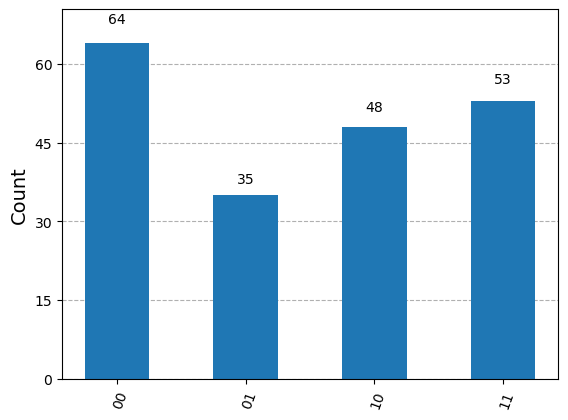

In [62]:
noisy_qiskit = tq.interface.qiskit.from_trueq_circ(circuit)

noisy_transpiled = transpile(noisy_qiskit,backend)
job = backend.run(noisy_transpiled,shots =  200)
noisy_counts = job.result().get_counts()

plot_histogram(noisy_counts)


In [63]:
n_compilations = 20
rc_circuits = tq.randomly_compile(circuit, n_compilations=n_compilations) ## RC with 30 COMPILATIONS

In [64]:
rc_circuits[0].draw() #EXAMPLE OF 1st CIRCUIT

DisplayWrapper(<svg xmlns="http://w...)

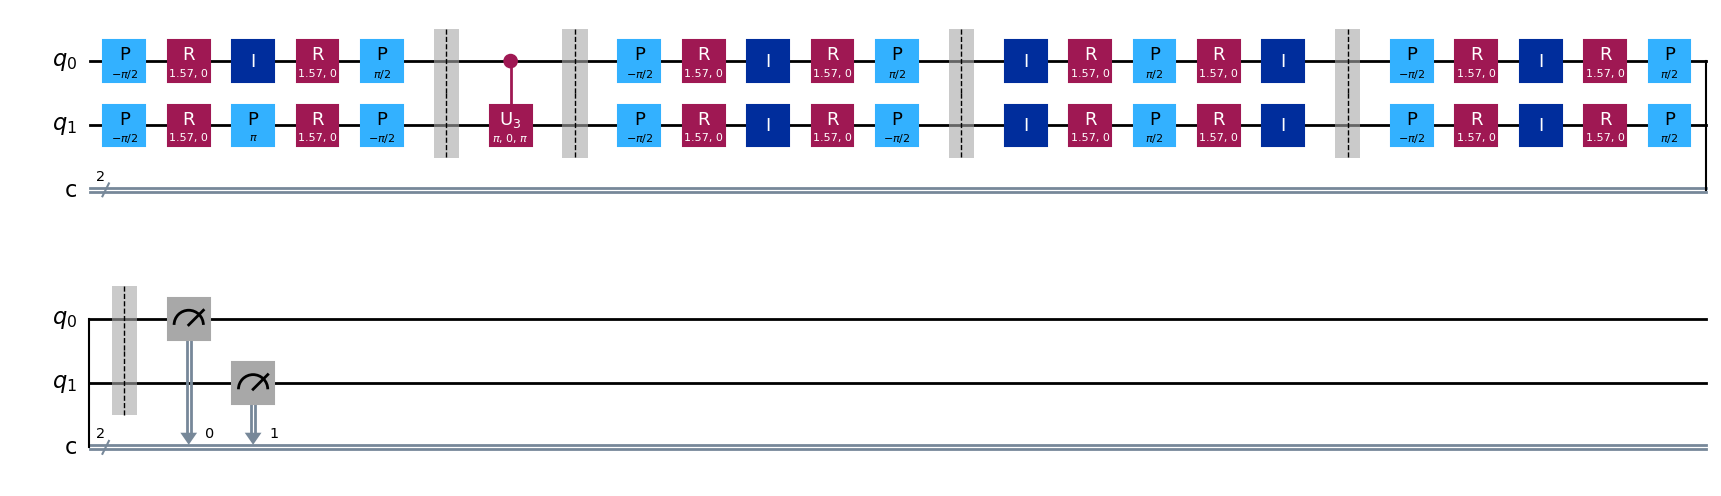

In [65]:
qiskit_circuits = [tq.interface.qiskit.from_trueq_circ(i) for i in rc_circuits] ## CONVERTING ALL TRUEQ CIRCUITS INTO QISKIT
qiskit_circuits[0].draw('mpl') ## THIS IS HOW THE TRUEQ CIRCUIT ABOVE LOOKS IN QISKIT

In [66]:
transpiled_circuits = transpile(qiskit_circuits, backend) ## TRANSPILED ALL THE QISKIT CIRCUITS

In [78]:

final_count = []
count_dict = defaultdict(int)

for circuit in transpiled_circuits:
    job = backend.run(circuit,shots =  100)
    counts = job.result().get_counts()
    final_count.append(counts)

In [79]:
final_count ## LIST OF FINAL COUNT OF ALL 20 CIRCUITS

[{'01': 37, '11': 18, '00': 14, '10': 31},
 {'01': 24, '11': 23, '00': 26, '10': 27},
 {'00': 24, '11': 28, '10': 16, '01': 32},
 {'01': 27, '00': 22, '11': 30, '10': 21},
 {'01': 18, '11': 18, '10': 29, '00': 35},
 {'01': 27, '11': 24, '00': 26, '10': 23},
 {'01': 25, '11': 26, '10': 26, '00': 23},
 {'01': 24, '00': 22, '10': 31, '11': 23},
 {'01': 25, '11': 28, '10': 24, '00': 23},
 {'00': 24, '11': 29, '10': 28, '01': 19},
 {'01': 30, '00': 21, '11': 27, '10': 22},
 {'01': 23, '11': 24, '00': 28, '10': 25},
 {'01': 19, '00': 23, '10': 35, '11': 23},
 {'10': 16, '00': 36, '11': 27, '01': 21},
 {'01': 27, '10': 25, '00': 25, '11': 23},
 {'01': 32, '11': 28, '00': 19, '10': 21},
 {'01': 19, '00': 27, '11': 29, '10': 25},
 {'01': 31, '10': 20, '00': 34, '11': 15},
 {'01': 31, '11': 21, '00': 24, '10': 24},
 {'01': 23, '00': 27, '10': 24, '11': 26}]

In [80]:
for counts in final_count: ## THIS CODE ADDS ALL THE COUNTS FROM THE 20 CIRCUITS
    for key, value in counts.items():
        count_dict[key] += value

rc_result = count_dict 

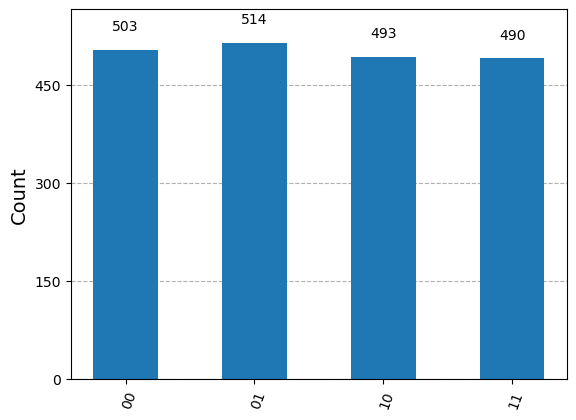

In [81]:
plot_histogram(rc_result) ## PLOT OF ADDITION OF ALL THE COUNTS

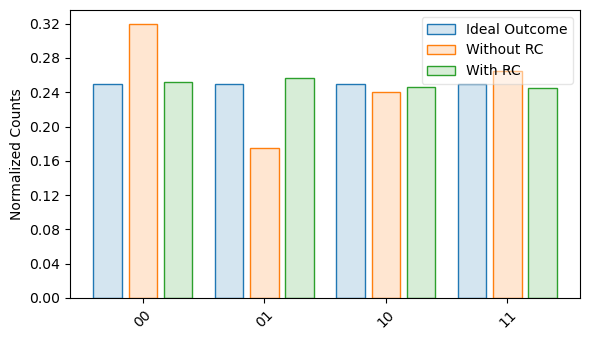

In [82]:
tq_rc_result = Results(rc_result)
tq_noisy_result = Results(noisy_counts)


tq.visualization.plot_results(
    ideal_result,
    tq_noisy_result,
    tq_rc_result,
    labels=["Ideal Outcome", "Without RC", "With RC"],
)

In [83]:
def my_tvd(result_1, result_2):
    
    result_1_dict = result_1.to_dict()['content']['value']
    result_2_dict = result_2.to_dict()['content']['value']

    keys = set(result_1_dict.keys()).union(set(result_2_dict.keys()))
    
    # Compute the absolute differences for each key
    tvd = 0.5 * sum(abs(result_1_dict.get(k, 0) - result_2_dict.get(k, 0)) for k in keys)
    
    return tvd

In [84]:
my_tvd(ideal_result,tq_rc_result.normalized())

0.008500000000000008

In [85]:
my_tvd(ideal_result,tq_noisy_result.normalized())

0.085

In [86]:
def cumulative_sum_dicts(dicts):
    """
    Returns a list of cumulative sum of dictionaries.
    """
    if not dicts:
        return []
    
    keys = dicts[0].keys()
    cumulative = {key: 0 for key in keys}
    result = []

    for d in dicts:
        cumulative = {key: cumulative[key] + d[key] for key in keys}
        result.append(cumulative.copy())

    return result


In [87]:
rc_steps = cumulative_sum_dicts(final_count)

rc_steps

[{'01': 37, '11': 18, '00': 14, '10': 31},
 {'01': 61, '11': 41, '00': 40, '10': 58},
 {'01': 93, '11': 69, '00': 64, '10': 74},
 {'01': 120, '11': 99, '00': 86, '10': 95},
 {'01': 138, '11': 117, '00': 121, '10': 124},
 {'01': 165, '11': 141, '00': 147, '10': 147},
 {'01': 190, '11': 167, '00': 170, '10': 173},
 {'01': 214, '11': 190, '00': 192, '10': 204},
 {'01': 239, '11': 218, '00': 215, '10': 228},
 {'01': 258, '11': 247, '00': 239, '10': 256},
 {'01': 288, '11': 274, '00': 260, '10': 278},
 {'01': 311, '11': 298, '00': 288, '10': 303},
 {'01': 330, '11': 321, '00': 311, '10': 338},
 {'01': 351, '11': 348, '00': 347, '10': 354},
 {'01': 378, '11': 371, '00': 372, '10': 379},
 {'01': 410, '11': 399, '00': 391, '10': 400},
 {'01': 429, '11': 428, '00': 418, '10': 425},
 {'01': 460, '11': 443, '00': 452, '10': 445},
 {'01': 491, '11': 464, '00': 476, '10': 469},
 {'01': 514, '11': 490, '00': 503, '10': 493}]

In [88]:
y = [my_tvd(ideal_result,Results(a).normalized()) for a in rc_steps]
y


[0.18,
 0.09499999999999997,
 0.060000000000000095,
 0.0500000000000001,
 0.02600000000000012,
 0.02500000000000009,
 0.021428571428571533,
 0.022500000000000006,
 0.018888888888888886,
 0.013999999999999999,
 0.01454545454545457,
 0.011666666666666645,
 0.013846153846153855,
 0.0035714285714285587,
 0.004666666666666666,
 0.006250000000000089,
 0.004117647058823545,
 0.006666666666666654,
 0.00894736842105262,
 0.008500000000000008]

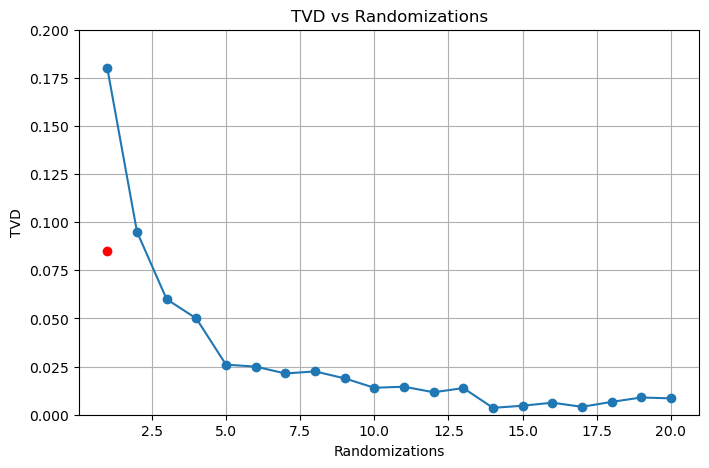

In [91]:
x_values = list(range(1, len(y) + 1))
plt.figure(figsize=(8, 5))
plt.plot(x_values, y, marker='o')
plt.scatter(1, my_tvd(ideal_result,tq_noisy_result.normalized()), c = 'red')
plt.xlabel("Randomizations")
plt.ylabel("TVD")
plt.ylim(0,0.2)
plt.title("TVD vs Randomizations")
plt.grid(True)
plt.show()

Now I will run 2000 shots on the original circuit to check if the TVD decreases by just increasing the circuit.

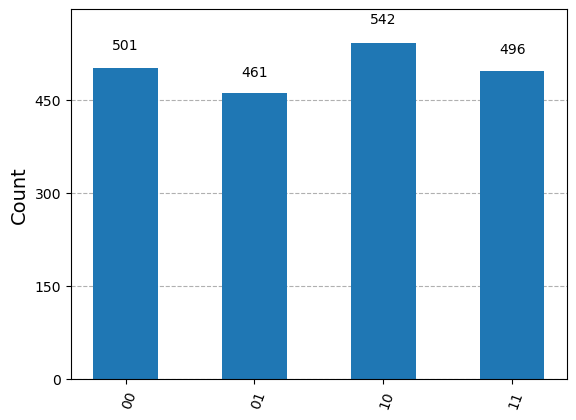

In [ ]:

final_count = []
count_dict = defaultdict(int)

noisy_qiskit = tq.interface.qiskit.from_trueq_circ(circuit)
noisy_transpiled = transpile(noisy_qiskit,backend)

for i in range(20):
    job = backend.run(noisy_transpiled,shots =  100)
    noisy_counts = job.result().get_counts()
    final_count.append(noisy_counts)

for counts in final_count:
    for key, value in counts.items():
        count_dict[key] += value

count_dict 

plot_histogram(count_dict) 

In [102]:
noisy_steps = cumulative_sum_dicts(final_count)

noisy_steps

[{'01': 22, '11': 28, '00': 24, '10': 26},
 {'01': 40, '11': 51, '00': 49, '10': 60},
 {'01': 65, '11': 74, '00': 75, '10': 86},
 {'01': 88, '11': 95, '00': 105, '10': 112},
 {'01': 119, '11': 114, '00': 125, '10': 142},
 {'01': 141, '11': 141, '00': 147, '10': 171},
 {'01': 171, '11': 169, '00': 166, '10': 194},
 {'01': 193, '11': 190, '00': 198, '10': 219},
 {'01': 222, '11': 214, '00': 223, '10': 241},
 {'01': 244, '11': 237, '00': 248, '10': 271},
 {'01': 269, '11': 261, '00': 274, '10': 296},
 {'01': 297, '11': 289, '00': 296, '10': 318},
 {'01': 312, '11': 318, '00': 320, '10': 350},
 {'01': 335, '11': 350, '00': 339, '10': 376},
 {'01': 355, '11': 374, '00': 370, '10': 401},
 {'01': 375, '11': 396, '00': 394, '10': 435},
 {'01': 395, '11': 419, '00': 419, '10': 467},
 {'01': 423, '11': 445, '00': 441, '10': 491},
 {'01': 438, '11': 467, '00': 475, '10': 520},
 {'01': 461, '11': 496, '00': 501, '10': 542}]

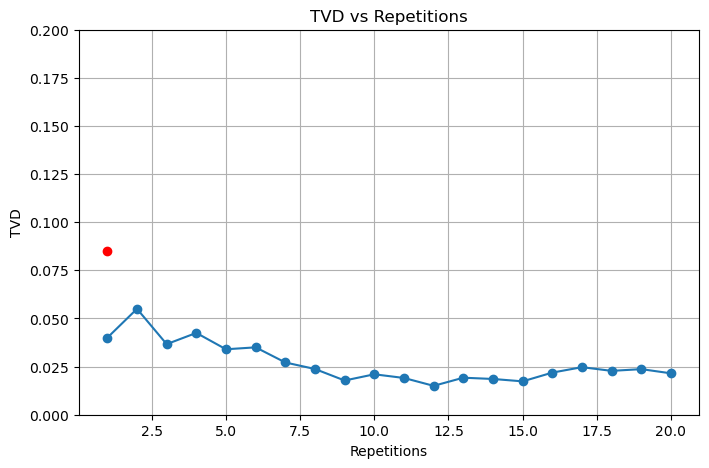

In [104]:
y = [my_tvd(ideal_result,Results(a).normalized()) for a in noisy_steps]

x_values = list(range(1, len(y) + 1))
plt.figure(figsize=(8, 5))
plt.plot(x_values, y, marker='o')
plt.scatter(1, my_tvd(ideal_result,tq_noisy_result.normalized()), c = 'red')
plt.xlabel("Repetitions")
plt.ylabel("TVD")
plt.ylim(0,0.2)
plt.title("TVD vs Repetitions")
plt.grid(True)
plt.show()
